In [1]:
import PIL
import time
import math
import copy
import torch
import random
import glob as gb
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import resnet50_128_redesign as model
import resnet50_128B8 as model
from PIL import Image
from tqdm import tqdm,trange
from torchsummary import summary
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from torchvision import transforms, utils
from sklearn.metrics import accuracy_score
from DataProcessing import process_dataloder
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [2]:
dataloaders, class_names, dataset_sizes, expA = process_dataloder()
print("After augmentation")
print(dataset_sizes)
print(class_names)
print(expA) 

train:   0%|          | 6/10448 [00:00<03:13, 54.10it/s]

----------
folders for train and test:  245 83
----------
data for train and test:
['negative', 'positive', 'surprise', 'non_micro-expression']
train [2168, 1856, 1408, 5016]
test [832, 600, 576, 1816]
dataset_size: {'train': [0, 10448], 'test': [10448, 14272]}
---------- load data ----------


test:   0%|          | 12/3824 [00:00<00:32, 118.04it/s]

---------- load data ----------


test: 100%|██████████| 3824/3824 [00:25<00:00, 150.32it/s]

Data loading complete in 1m 31s
After augmentation
{'train': 43272, 'test': 16000}
['negative', 'positive', 'surprise', 'non_micro-expression']
{'train': [10840, 11136, 11264, 10032], 'test': [4160, 3600, 4608, 3632]}


In [3]:
def cyclical_lr(stepsize, min_lr, max_lr):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [4]:
def training(phase, model, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    nb_classes = 4
    confusion_matrix = torch.zeros(nb_classes, nb_classes)

    # Iterate over data.        
    for inputs, labels in dataloaders[phase]:            
        inputs = inputs.to(device)            
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            
            outputs = model(inputs)            
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)    
            
            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                clip_grad_norm_(model.parameters(), 5)
                optimizer.step()  
            if phase == 'test':              
                with torch.no_grad():
                    for t, p in zip(labels.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) 
        
    if phase == 'test':
        print(confusion_matrix)

    return running_loss, running_corrects     

In [5]:
def epoch_mode(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    logs = []
    Acc = {'train':[],'test':[]}
    Los = {'train':[],'test':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss, running_corrects = training(phase, model, criterion, optimizer)
            if phase == 'train':
                scheduler.step()
                lr_sched_test = scheduler.get_lr()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())      
            Acc[phase].append(epoch_acc)
            Los[phase].append(epoch_loss)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, Acc, Los

In [6]:
#download the pre-trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# modelRes50 = model.resnet50_128(weights_path='./model/resnet50_128.pth')
# modelRes50.add_module("feat_extract1",nn.Conv2d(128, 64, kernel_size=[1, 1], stride=(1, 1), bias=False))
# modelRes50.add_module("feat_extract2",nn.Conv2d(64, 4, kernel_size=[1, 1], stride=(1, 1), bias=False))
# modelRes50.add_layers([modelRes50.feat_extract1, modelRes50.feat_extract2])
# modelRes50 = modelRes50.to(device)
# features_layers = 91

In [7]:
#Freeze layers before classifier
def freezing(model, features_layers):
    lay_mark = 0;
    para_list = []
    for param in modelRes50.parameters():
        if lay_mark > features_layers:
            para_list.append(param)
        if lay_mark <= features_layers:
            param.requires_grad = False
        lay_mark += 1
    return model, para_list

In [8]:
#final layer are being optimized 
# criterion = nn.CrossEntropyLoss()
# optimizer_ft = optim.SGD(para_list, lr=0.00035, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0/74
----------
train Loss: 0.6378 Acc: 0.9185
tensor([[   0., 4160.,    0.,    0.],
        [   0., 3600.,    0.,    0.],
        [   0., 4608.,    0.,    0.],
        [   0., 3632.,    0.,    0.]])
test Loss: 5.5066 Acc: 0.2250
Epoch 1/74
----------
train Loss: 0.5793 Acc: 0.9186
tensor([[   0., 4160.,    0.,    0.],
        [   0., 3600.,    0.,    0.],
        [   0., 4608.,    0.,    0.],
        [   0., 3632.,    0.,    0.]])
test Loss: 5.1549 Acc: 0.2250
Epoch 2/74
----------
train Loss: 0.6329 Acc: 0.9096
tensor([[   0., 4160.,    0.,    0.],
        [   0., 3600.,    0.,    0.],
        [   0., 4608.,    0.,    0.],
        [   0., 3632.,    0.,    0.]])
test Loss: 10.4189 Acc: 0.2250
Epoch 3/74
----------
train Loss: 0.6462 Acc: 0.9030
tensor([[   0., 4160.,    0.,    0.],
        [   0., 3600.,    0.,    0.],
        [   0., 4608.,    0.,    0.],
        [   0., 3632.,    0.,    0.]])
test Loss: 8.9901 Acc: 0.2250
Epoch 4/74
----------
train Loss: 0.6410 Acc: 0.8963
te

train Loss: 0.2416 Acc: 0.9292
tensor([[ 116., 1726.,  905., 1413.],
        [  48., 2290.,  565.,  697.],
        [ 146., 3733.,  375.,  354.],
        [  54., 1739.,  118., 1721.]])
test Loss: 2.8096 Acc: 0.2814
Epoch 35/74
----------
train Loss: 0.2381 Acc: 0.9302
tensor([[ 115., 1709.,  918., 1418.],
        [  47., 2276.,  575.,  702.],
        [ 142., 3725.,  375.,  366.],
        [  53., 1733.,  117., 1729.]])
test Loss: 2.7877 Acc: 0.2809
Epoch 36/74
----------
train Loss: 0.2348 Acc: 0.9310
tensor([[ 116., 1693.,  937., 1414.],
        [  39., 2266.,  586.,  709.],
        [ 139., 3712.,  376.,  381.],
        [  52., 1721.,  117., 1742.]])
test Loss: 2.7677 Acc: 0.2812
Epoch 37/74
----------
train Loss: 0.2315 Acc: 0.9321
tensor([[ 116., 1678.,  948., 1418.],
        [  36., 2261.,  594.,  709.],
        [ 137., 3709.,  378.,  384.],
        [  51., 1710.,  121., 1750.]])
test Loss: 2.7491 Acc: 0.2816
Epoch 38/74
----------
train Loss: 0.2284 Acc: 0.9331
tensor([[ 116., 1663.

train Loss: 0.1667 Acc: 0.9487
tensor([[1.0600e+02, 1.5510e+03, 1.0820e+03, 1.4210e+03],
        [6.0000e+00, 2.0680e+03, 6.7900e+02, 8.4700e+02],
        [6.7000e+01, 3.4090e+03, 6.0100e+02, 5.3100e+02],
        [3.0000e+00, 1.6440e+03, 2.1700e+02, 1.7680e+03]])
test Loss: 2.5766 Acc: 0.2839
Epoch 69/74
----------
train Loss: 0.1653 Acc: 0.9490
tensor([[1.0700e+02, 1.5510e+03, 1.0890e+03, 1.4130e+03],
        [6.0000e+00, 2.0600e+03, 6.8000e+02, 8.5400e+02],
        [6.6000e+01, 3.3900e+03, 6.1600e+02, 5.3600e+02],
        [2.0000e+00, 1.6420e+03, 2.2100e+02, 1.7670e+03]])
test Loss: 2.5762 Acc: 0.2844
Epoch 70/74
----------
train Loss: 0.1640 Acc: 0.9493
tensor([[1.0800e+02, 1.5500e+03, 1.0880e+03, 1.4140e+03],
        [6.0000e+00, 2.0580e+03, 6.8000e+02, 8.5600e+02],
        [6.6000e+01, 3.3790e+03, 6.2500e+02, 5.3800e+02],
        [1.0000e+00, 1.6310e+03, 2.3400e+02, 1.7660e+03]])
test Loss: 2.5758 Acc: 0.2848
Epoch 71/74
----------
train Loss: 0.1627 Acc: 0.9496
tensor([[1.1100e+0

ValueError: x and y must have same first dimension, but have shapes (50,) and (75,)

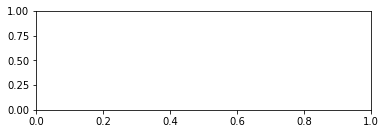

In [9]:
# Parameters
lr_max = 1*10e-1

factor = 6
end_lr = lr_max
iter=0
total_logs = []
features_layers = 91
step_size = 4*len(dataloaders["train"])
Epo = [x for x in range(50)]

# Do 3 sequential runs
for run in tqdm(range(3)):
    # Instantiate the model 
    modelRes50 = model.resnet50_128(weights_path='./model/resnet50_128.pth')
   # modelRes50.add_module("feat_extract1",nn.Conv2d(128, 64, kernel_size=[1, 1], stride=(1, 1), bias=False))
   # modelRes50.add_module("feat_extract2",nn.Conv2d(64, 4, kernel_size=[1, 1], stride=(1, 1), bias=False))
    #modelRes50.add_layers([modelRes50.feat_extract1, modelRes50.feat_extract2])
    modelRes50.add_module("Add_pool",nn.AvgPool2d(kernel_size=[14, 14], stride=[1, 1], padding=0))
    modelRes50.add_module("feat_extract0",nn.Conv2d(1024, 4, kernel_size=[1, 1], stride=(1, 1), bias=False))
    modelRes50.add_layers([modelRes50.Add_pool, modelRes50.feat_extract0])
    
    modelRes50, para_list = freezing(modelRes50, features_layers)
    modelRes50 = modelRes50.to(device)
    
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    # Define the optimizer 
    
    optimizer_ft = optim.SGD(para_list, lr=1.)    
    clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
    exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_ft, [clr])
    modelRes50, Acc, Los = epoch_mode(modelRes50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=75) 
    
    plt.title('Accuracy and Loss for testing and testing')
    plt.subplot(2, 1, 1)   
    plt.plot(Epo, Acc["train"], 'g--')
    plt.plot(Epo, Acc["test"], 'r--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend('Training accuracy', 'Testing accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(Epo, Los["train"], 'y--')
    plt.plot(Epo, Los["test"], 'b--')    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend('Training loss', 'Testing loss')
    plt.show()

In [ ]:
# modelRes50, Acc, Los = epoch_mode(modelRes50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

In [ ]:
# Epo = [x for x in range(5)]
    
# plt.title('Accuracy and Loss for testing and testing')
# plt.subplot(2, 1, 1)   
# plt.plot(Epo, Acc["train"], 'g^')
# plt.plot(Epo, Acc["test"], 'r--')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend('Training accuracy', 'Testing accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(Epo, Los["train"], 'y*')
# plt.plot(Epo, Los["test"], 'bs')    
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend('Training loss', 'Testing loss')
# plt.show()

In [ ]:

# nb_classes = 4

# confusion_matrix = torch.zeros(nb_classes, nb_classes)
# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(dataloaders['test']):
#         inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = modelRes50(inputs)
#         _, preds = torch.max(outputs, 1)
#         for t, p in zip(classes.view(-1), preds.view(-1)):
#                 confusion_matrix[t.long(), p.long()] += 1
# print(class_names)
# print(confusion_matrix)